In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [2]:
# --- CONFIGURATION ---
TICKER = "^NDX"
START_DATE = "2015-06-01"
END_DATE = "2025-06-01"


In [3]:
# --- DATA FETCHING ---
df = yf.download('^NDX',start=START_DATE, end=END_DATE)
df.dropna(inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_10088\3599879773.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^NDX',start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [22]:
df.shape

(2516, 5)

In [23]:
df

Price,Close,High,Low,Open,Volume
Ticker,^NDX,^NDX,^NDX,^NDX,^NDX
Date,,,,,
2015-06-01,4521.850098,4535.430176,4488.169922,4530.029785,1902120000
2015-06-02,4508.890137,4531.080078,4486.189941,4503.759766,1729750000
2015-06-03,4519.859863,4539.350098,4512.439941,4531.040039,1852680000
2015-06-04,4487.029785,4526.209961,4475.049805,4501.729980,1813960000
2015-06-05,4477.189941,4493.430176,4452.319824,4483.430176,1842890000
...,...,...,...,...,...
2025-05-23,20915.660156,21025.580078,20777.970703,20806.369141,8730370000
2025-05-27,21414.990234,21429.320312,21145.130859,21201.449219,8927760000


In [24]:
df.columns

MultiIndex([( 'Close', '^NDX'),
            (  'High', '^NDX'),
            (   'Low', '^NDX'),
            (  'Open', '^NDX'),
            ('Volume', '^NDX')],
           names=['Price', 'Ticker'])

In [4]:
df.columns = [f"{col[0]}" for col in df.columns]

In [5]:
# --- TECHNICAL INDICATORS ---
df['rsi'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
df['macd'] = ta.trend.MACD(close=df['Close']).macd()
df['macd_signal'] = ta.trend.MACD(close=df['Close']).macd_signal()
df['stoch'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()
df['willr'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
df['cci'] = ta.trend.CCIIndicator(df['High'], df['Low'], df['Close']).cci()
df['adx'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close']).adx()
df['roc'] = ta.momentum.ROCIndicator(df['Close']).roc()
df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
df['ema_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
df['bb_bbm'] = ta.volatility.BollingerBands(df['Close']).bollinger_mavg()
df['bb_bbh'] = ta.volatility.BollingerBands(df['Close']).bollinger_hband()
df['bb_bbl'] = ta.volatility.BollingerBands(df['Close']).bollinger_lband()

In [15]:


# --- TARGET CREATION ---
df['targetclass'] = (df['Close'].shift(-1) > df['Close']).astype(int)

In [7]:
# --- FEATURE SELECTION ---
features = [
    'rsi', 'macd', 'macd_signal', 'stoch', 'willr', 'cci',
    'adx', 'roc', 'obv', 'ema_10', 'sma_20',
    'bb_bbm', 'bb_bbh', 'bb_bbl'
]

In [8]:

df.dropna(inplace=True)
X = df[features]
y = df['targetclass']


In [9]:

# --- DATA SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [10]:
# --- FEATURE SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# --- MODEL COMPARISON SETUP ---
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    results[name] = (y_test, y_pred)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.35      0.09      0.15       150
           1       0.56      0.87      0.68       196

    accuracy                           0.53       346
   macro avg       0.45      0.48      0.41       346
weighted avg       0.47      0.53      0.45       346


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.44      0.23      0.30       150
           1       0.57      0.78      0.66       196

    accuracy                           0.54       346
   macro avg       0.50      0.50      0.48       346
weighted avg       0.51      0.54      0.50       346


=== XGBoost ===
              precision    recall  f1-score   support

           0       0.44      0.65      0.53       150
           1       0.58      0.37      0.45       196

    accuracy                           0.49       346
   macro avg       0.51      0.51      0.49       346
weigh

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:23:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== MLP Neural Net ===
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       150
           1       0.58      0.52      0.54       196

    accuracy                           0.51       346
   macro avg       0.51      0.51      0.51       346
weighted avg       0.52      0.51      0.51       346



c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


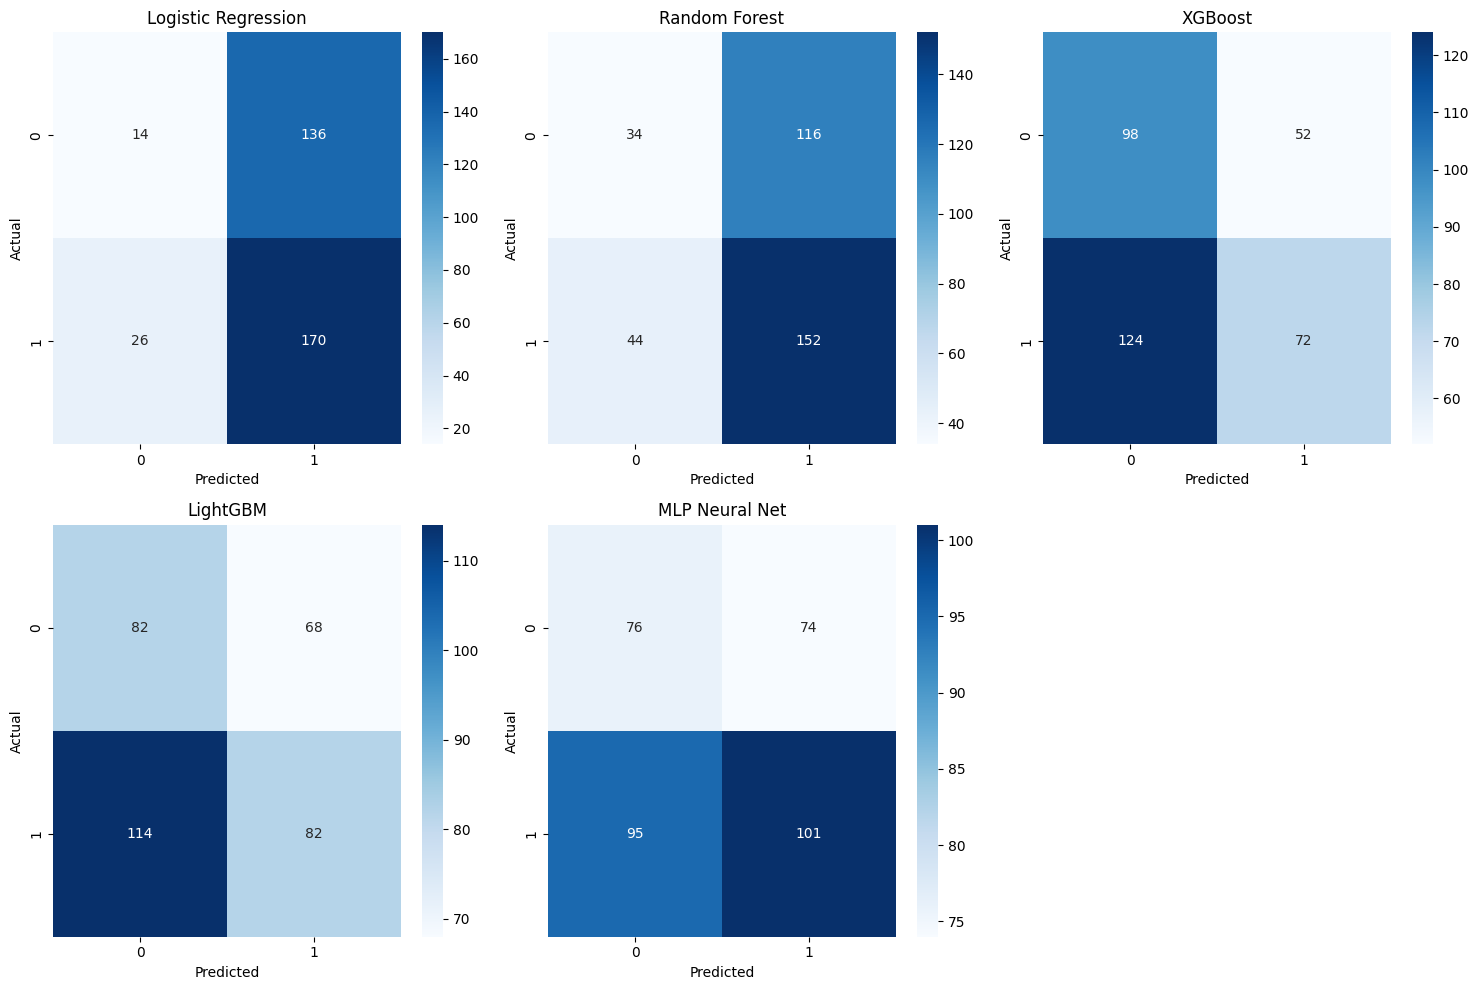

In [27]:

# --- CONFUSION MATRICES ---
plt.figure(figsize=(15, 10))
for i, (name, (y_true, y_pred)) in enumerate(results.items()):
    plt.subplot(2, 3, i+1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [5]:
df['rsi'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
df['macd'] = ta.trend.MACD(close=df['Close']).macd()
df['macd_signal'] = ta.trend.MACD(close=df['Close']).macd_signal()
df['stoch'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()
df['willr'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
df['cci'] = ta.trend.CCIIndicator(df['High'], df['Low'], df['Close']).cci()
df['adx'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close']).adx()
df['roc'] = ta.momentum.ROCIndicator(df['Close']).roc()
df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
df['ema_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
df['bb_bbm'] = ta.volatility.BollingerBands(df['Close']).bollinger_mavg()
df['bb_bbh'] = ta.volatility.BollingerBands(df['Close']).bollinger_hband()
df['bb_bbl'] = ta.volatility.BollingerBands(df['Close']).bollinger_lband()

# --- Create target: 1 if price goes up next day, else 0 ---
df['return'] = df['Close'].pct_change().shift(-1)
df['targetclass'] = df['return'].apply(lambda x: 1 if x > 0.003 else (0 if x < -0.003 else np.nan))

df.dropna(inplace=True)
print(df.head())
# --- Features and scaling ---
features = [
    'rsi', 'macd', 'macd_signal', 'stoch', 'willr', 'cci',
    'adx', 'roc', 'obv', 'ema_10', 'sma_20', 'bb_bbm', 'bb_bbh', 'bb_bbl'
]
X = df[features].values
y = df['targetclass'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(df.head())
# --- Create sequences for LSTM ---
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=60)

# --- Train/test split ---
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# --- Model builder function ---
def build_lstm_model(input_shape, lr=0.001, activation='relu'):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# --- Hyperparameter configurations ---
configs = [
    {"batch_size": 32, "epochs": 20, "lr": 0.001},
    {"batch_size": 64, "epochs": 30, "lr": 0.0005},
    {"batch_size": 128, "epochs": 40, "lr": 0.0001},
]



class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))



early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Train and evaluate models ---
for idx, cfg in enumerate(configs, 1):
    print(f"\n--- Model {idx}: {cfg} ---")
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lr=cfg["lr"])
    history = model.fit(
        X_train, y_train,
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        validation_data=(X_test, y_test),
        verbose=0,
        class_weight=class_weights,
        callbacks=[early_stop]
    )
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(classification_report(y_test, y_pred))

                  Close         High          Low         Open      Volume  \
Date                                                                         
2015-07-17  4661.600098  4661.600098  4624.680176  4635.479980  1854450000   
2015-07-21  4674.410156  4686.359863  4661.759766  4679.540039  1774570000   
2015-07-22  4623.240234  4643.830078  4604.529785  4604.970215  2035730000   
2015-07-23  4602.830078  4641.580078  4592.490234  4627.560059  2003310000   
2015-07-24  4557.370117  4632.060059  4552.399902  4630.950195  2004380000   

                  rsi       macd  macd_signal       stoch      willr  ...  \
Date                                                                  ...   
2015-07-17  69.928892  20.151006    -6.787587  100.000000  -0.000000  ...   
2015-07-21  70.248101  41.107504     9.052447   94.365470  -5.634530  ...   
2015-07-22  62.219823  43.423289    15.926616   79.744656 -20.255344  ...   
2015-07-23  59.308304  43.114638    21.364220   73.912849 -26.087151


--- Model 1: {'batch_size': 32, 'epochs': 20, 'lr': 0.001} ---
11/11 [==============================] - 0s 9ms/step
Best threshold by F1 score: 0.50 with F1 = 0.7301
              precision    recall  f1-score   support

         0.0       1.00      0.02      0.04       142
         1.0       0.57      1.00      0.73       188

    accuracy                           0.58       330
   macro avg       0.79      0.51      0.39       330
weighted avg       0.76      0.58      0.43       330



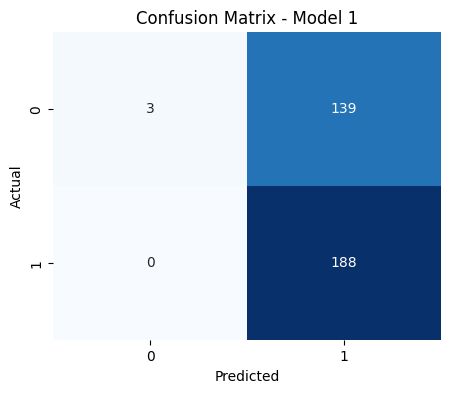


--- Model 2: {'batch_size': 64, 'epochs': 30, 'lr': 0.0005} ---
11/11 [==============================] - 0s 9ms/step
Best threshold by F1 score: 0.32 with F1 = 0.7301
              precision    recall  f1-score   support

         0.0       1.00      0.02      0.04       142
         1.0       0.57      1.00      0.73       188

    accuracy                           0.58       330
   macro avg       0.79      0.51      0.39       330
weighted avg       0.76      0.58      0.43       330



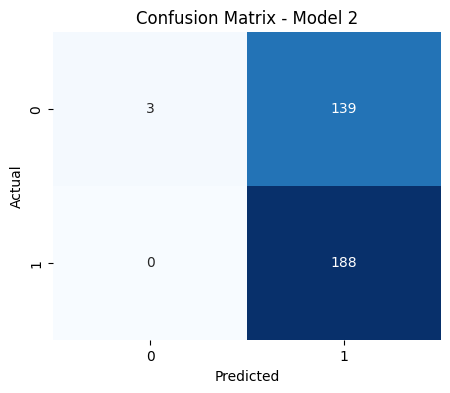


--- Model 3: {'batch_size': 128, 'epochs': 40, 'lr': 0.0001} ---
11/11 [==============================] - 0s 9ms/step
Best threshold by F1 score: 0.43 with F1 = 0.7287
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.03       142
         1.0       0.57      1.00      0.73       188

    accuracy                           0.58       330
   macro avg       0.79      0.51      0.38       330
weighted avg       0.76      0.58      0.43       330



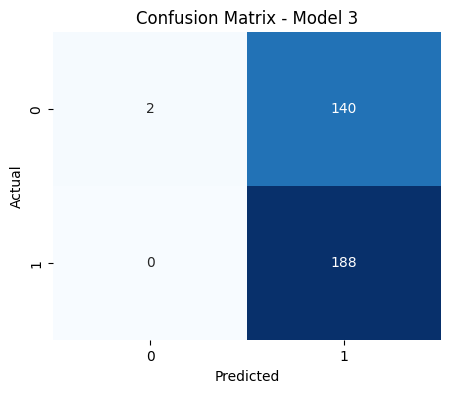

In [ ]:
from sklearn.metrics import classification_report, f1_score
# Your original feature engineering code
df['rsi'] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
df['macd'] = ta.trend.MACD(close=df['Close']).macd()
df['macd_signal'] = ta.trend.MACD(close=df['Close']).macd_signal()
df['stoch'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close']).stoch()
df['willr'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
df['cci'] = ta.trend.CCIIndicator(df['High'], df['Low'], df['Close']).cci()
df['adx'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close']).adx()
df['roc'] = ta.momentum.ROCIndicator(df['Close']).roc()
df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
df['ema_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
df['bb_bbm'] = ta.volatility.BollingerBands(df['Close']).bollinger_mavg()
df['bb_bbh'] = ta.volatility.BollingerBands(df['Close']).bollinger_hband()
df['bb_bbl'] = ta.volatility.BollingerBands(df['Close']).bollinger_lband()

# --- Create target: 1 if price goes up next day, else 0 ---
df['return'] = df['Close'].pct_change().shift(-1)
df['targetclass'] = df['return'].apply(lambda x: 1 if x > 0.003 else (0 if x < -0.003 else np.nan))

df.dropna(inplace=True)

# --- Features and scaling ---
features = [
    'rsi', 'macd', 'macd_signal', 'stoch', 'willr', 'cci',
    'adx', 'roc', 'obv', 'ema_10', 'sma_20', 'bb_bbm', 'bb_bbh', 'bb_bbl'
]
X = df[features].values
y = df['targetclass'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Create sequences for LSTM ---
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=60)

# --- Train/test split ---
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# --- Model builder function ---
def build_lstm_model(input_shape, lr=0.001, activation='relu'):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# --- Hyperparameter configurations ---
configs = [
    {"batch_size": 32, "epochs": 20, "lr": 0.001},
    {"batch_size": 64, "epochs": 30, "lr": 0.0005},
    {"batch_size": 128, "epochs": 40, "lr": 0.0001},
]

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Function to find best threshold maximizing F1 score ---
def find_best_threshold(y_true, y_probs):
    best_threshold = 0.5
    best_f1 = 0
    thresholds = np.arange(0.1, 0.9, 0.01)
    for thresh in thresholds:
        y_pred_thresh = (y_probs >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    return best_threshold, best_f1

# --- Train and evaluate models ---
for idx, cfg in enumerate(configs, 1):
    print(f"\n--- Model {idx}: {cfg} ---")
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), lr=cfg["lr"])
    history = model.fit(
        X_train, y_train,
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        validation_data=(X_test, y_test),
        verbose=0,
        class_weight=class_weights,
        callbacks=[early_stop]
    )
    y_probs = model.predict(X_test).flatten()
    best_thresh, best_f1 = find_best_threshold(y_test, y_probs)
    print(f"Best threshold by F1 score: {best_thresh:.2f} with F1 = {best_f1:.4f}")
    y_pred = (y_probs >= best_thresh).astype(int)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Model {idx}')
    plt.show()
